# Example: Modeling the Payout and Profit of Long and Short American-style Put Contracts

## Background
A `put` option is a financial contract that gives the holder the right, but not the obligation, to sell a specified asset, such as stocks, commodities, or currencies, at a predetermined price within a specified time period. Let's consider stock as the underlying asset. A single standard `put` contract controls `100` shares of stock.

In the case of [American](https://www.investopedia.com/terms/a/americanoption.asp) style [put contracts](https://www.investopedia.com/terms/p/putoption.asp), the option buyer can exercise their right at any point between when the contract is purchased and the expiration date. On the other hand, buyers of [European](https://www.investopedia.com/terms/e/europeanoption.asp) style contracts can only exercise their right on the expiration date. 

The business case for buying (or selling) `put` contracts:
* __Buyer (long)__: From the buyer's perspective, `put` contracts allow an investor to benefit from the price movement of `XYZ` to the downside _without_ purchasing `XYZ`. Further, `put` options (again from the buyer's perspective) have _limited downside risk_, i.e., the maximum amount that the holder of the `put` option can lose is the premium paid for the option. Finally, `put` contracts are a mechanism to sell shares of `XYZ` at the strike price of $K$ instead of the market price of $S$. 
* __Seller (short)__: From the seller's perspective, the motivation for selling a `put` contract is to collect the premium $\mathcal{P}$. Put contracts also allow the seller to benefit from the price movement of `XYZ` to the upside _without_ purchasing `XYZ`. However, for a seller, `put` options have _unlimted downside_ risk; thus, `put` options are often only sold by investors who have set aside the required capital to purchase the required number of shares of `XYZ` (known as a [cash secured put position](https://www.fidelity.com/learning-center/investment-products/options/know-about-cash-covered-puts)). Finally, `put` options offer the seller the opportunity to buy shares of `XYZ` at the strike price of $K-\mathcal{P}$ instead of the market price of $S$.

## Payoff, Profit and Premium
The payoff of a `put` contract at expiration `T` days in the future is defined as

$$V_{p}(K,S(T)) = \max\left(K - S(T),~0.0\right)$$

where $K$ denotes the strike price and $S(T)$ denotes the share price of the underlying asset `T` days in the future (at expiration). The right (but not the obligation) to sell shares is not free, the seller charges the buyer a preimum for each `put` contract $\mathcal{P}_{p}$. Thus, from the perspective of the buyer, the profit for the `put` contract $P_{p}$ is given by:

$$P_{p}(K,S(T)) = \hat{V}_{p}(K,S(T)) -  \mathcal{P}_{p}(K,S(T))$$

Finally, the premium (cost) for each `put` contract $\mathcal{P}_{p}(\dots)$ is defined by the expression:

$$\mathcal{P}_{p}(K,S(T))\geq\mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T)\Bigr)$$

where $\mathcal{D}_{T,0}(\bar{r})$ denotes the discount rate between the time when the contract was purchased `0` and contract expiration `T` days in the future. Option contracts using risk neutral pricing, thus, the discount rate $\bar{r}$ is typially taken as the interest rate on 10-year treasury notes. 

## Setup
Fill me in.

In [1]:
include("Include.jl")

premium

## Objectives
In this example, we'll compute the premium, payoff and profit for sample `put` option contracts. In particular:

* __Objective 1__: We'll begin with [European](https://www.investopedia.com/terms/e/europeanoption.asp) style contracts, where the contract can only be excersised at expiration. 
* __Objective 2__: We'll then contrast this perspective with [American](https://www.investopedia.com/terms/a/americanoption.asp) style `put` contracts where a contract can be excercised at any point between when the contract was purchased and expiration. 

## Objective 1: Premium, payoff and profit for a European Put contract

Let's begin by computing the premium $\mathcal{P}_{p}(K,S(T))$ the buyer must pay for a `put` contract. When early excersise is not allowed, the pricing formula is given by (the equality case):

$$\mathcal{P}_{p}(K,S(T)) = \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T))\Bigr)$$

which says the right (but not the obligation) to excercise the `put` contract is the expected value of the discounted future payoff from the contract. To compute the expectation, we simulate the future share price `T` days in the future using a [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion#:~:text=A%20geometric%20Brownian%20motion%20(GBM,a%20Wiener%20process)%20with%20drift.) model for the future share price:

$$S(T) = S_{\circ}\exp\Biggl[\left(\bar{r}-\frac{\sigma^{2}}{2}\right)\cdot{T} + (\sigma\sqrt{T})\cdot{Z_{t}(0,1)}\Biggr]$$

where we assume $S_{\circ}$ is the share price today, $\bar{r}$ denotes the risk-free rate (risk-neutral pricing), $\sigma$ denotes share price volatility and `T` denotes the number of days until contract expiration. Once we have the $\mathcal{P}_{p}(K,S(T))$, we can calculate (and visualize) the payoff and potential profit for the `put` contract.

### Implementation
Let's consider an example: We have a European `put` that expires in `T = 365` days with a strike price `K = 60.0`. The current share price is `S(0)=60.0`. Assume a risk free rate of return of `5%` and a implied volatility of `10%`. The correct answer is $\mathcal{P}_{p}(K,S(T))$ = 1.16 USD/share. Let's compute the premium using two appoaches:

* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model, and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European `put` option

We start by defining the problem parameters that are shared between the approaches:

In [2]:
Δt = (1.0/365.0);
Sₒ = 60.0;
K = 60.0;
T = 365.0*Δt;
r̄ = 0.05;
σ̄ = 0.10;

#### Approach 1: Monte Carlo estimate of European `put` contract price
Let's build an instance of the `MyGeometricBrownianMotionEquityModel` type which holds the value for the price simulation using the `build(...)` method and store in the `model` variable:

In [3]:
model = build(MyGeometricBrownianMotionEquityModel, (
        μ = r̄, σ = σ̄));

Next, we build an instance of the `MyEuropeanPutContractModel` type which holds the parameters for the `put` contract using the `build(...)` method. We store the contract model in the `put_contract_model` variable:

In [4]:
put_contract_model = build(MyEuropeanPutContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1));

We'll simulate the future share price at expiration $S(T)$ for different number of sample paths. We'll store these values in the `number_of_samples` array:

In [5]:
number_of_samples = range(1.0,stop=5,step=1.0) |> collect |> (x-> exp10.(x)) |> (x-> 5*Int.(x));

Finally, for each number of sample paths, we sample the geometric Brownian model instance using the `sample(...)` function, compute the payoff using `payoff(...)` function, compute the premium array which is stored in the `P̄` variable, and then compute the mean `premium`  and standard error `SE` of the expected discounted future contract payoff. We propulate a `DataFrame` instance that holds the data for each number of sample paths:

In [6]:
put_price_df = DataFrame(n = Int64[], premium = Float64[], SE = Float64[], CI95 = Float64[]);
for n ∈ number_of_samples
    S = sample(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
    P = payoff([put_contract_model], S);
    P̄ = (1/𝒟(r̄,T))*P[:,3];
    mean_value = mean(P̄);
    std_error_value = (1.0/sqrt(n))*std(P̄);
    CI95_value = 1.96*std_error_value;
    
    results_df = (
        
        n = n,
        premium = mean_value,
        SE = std_error_value,
        CI95 = CI95_value
    );
    
    push!(put_price_df, results_df);
end

put_price_df

Row,n,premium,SE,CI95
,Int64,Float64,Float64,Float64
1,50,1.40184,0.333767,0.654182
2,500,1.21779,0.106767,0.209264
3,5000,1.15856,0.0325904,0.0638771
4,50000,1.15946,0.0102505,0.0200911
5,500000,1.15971,0.00323139,0.00633352


#### Approach 2: Black–Scholes pricing formula for a European `put` contract
The [Black–Scholes pricing formula ](https://en.wikipedia.org/wiki/Black–Scholes_model) for a European `put` option is given by the expression:

$$\mathcal{P}_{p}(K,S(T)) = N(-d_{-})K\mathcal{D}^{-1}_{T,0}(\bar{r}) - N(-d_{+})S_{\circ}$$

where:

$$
\begin{eqnarray}
d_{+} & = & \frac{1}{\sigma\sqrt{T}}\left[\ln(\frac{S_{\circ}}{K}) + (r+\frac{\sigma^{2}}{2})T\right] \\
d_{-} & = & d_{+} - \sigma\sqrt{T}
\end{eqnarray}
$$

and $N(\dots)$ denotes the standard normal cumulative distribution function.

In [37]:
d₊ = (1/σ̄*sqrt(T))*(log(Sₒ/K)+(r̄+(σ̄^2)/2)*T);
d₋ = d₊ - σ̄*sqrt(T);
P = cdf(Normal(0,1), -d₋)*K*(1/𝒟(r̄,T)) - cdf(Normal(0,1), -d₊)*Sₒ |> x-> round(x,sigdigits=4)
println("The premium for the European put contract computed by Black-Scholes is: $(P) USD/share")

The premium for the European put contract computed by Black-Scholes is: 1.157 USD/share


### Visualize potential profit for an European `put` option at expiration
Now that we have calculated the contract premium, we can compute the potential profit and break even points for the `put` contract. First, let's update the contract model with the value of the premimum calculated using the [Black–Scholes pricing formula ](https://en.wikipedia.org/wiki/Black–Scholes_model):

In [8]:
put_contract_model.premium = P;

Next, we'll build a range values for $S(T)$, and then compute the payoff and profit arrays using the `payoff(...)` and `profit(...)` functions. These functions take an array of contracts, and array of values for $S(T)$ and the return the payoff and the profit:

In [33]:
S_array = range(55.0,step=0.1,stop = 65.0) |> collect;
payoff_array = payoff([put_contract_model], S_array);
profit_array = profit([put_contract_model], S_array);

Finally, we can plot the share price at expiration $S(T)$ versus the payoff (profit) for the buyer (solid lines) and the seller (dashed lines):

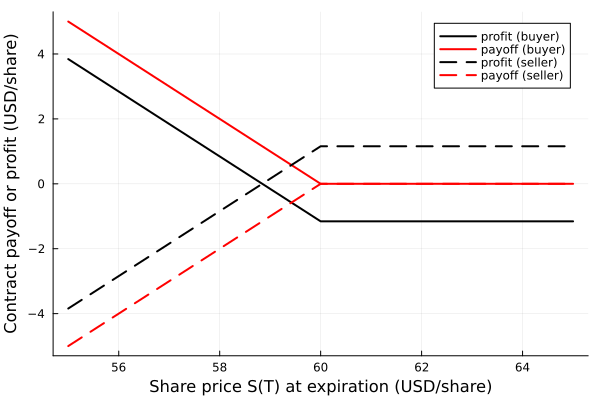

In [32]:
plot(profit_array[:,1],profit_array[:,2], c=:black, label="profit (buyer)", lw=2)
plot!(payoff_array[:,1],payoff_array[:,end], c=:red, label="payoff (buyer)", lw=2)
plot!(profit_array[:,1],-1*profit_array[:,2], c=:black, label="profit (seller)", linestyle=:dash, lw=2)
plot!(payoff_array[:,1],-1*payoff_array[:,end], c=:red, label="payoff (seller)", linestyle=:dash, lw=2)
xlabel!("Share price S(T) at expiration (USD/share)",fontsize=18)
ylabel!("Contract payoff or profit (USD/share)",fontsize=18)

### Breakeven
The breakeven point for `put` contract is the strike price minus the cost of the contract:

$$\mathcal{B}_{p}(K,S(T)) = K - \mathcal{P}(K,S(T))$$

The break-even price for the European `put` contract is given by:

In [39]:
breakeven_european_put = K - P;
println("The Breakeven for the European put contract is: B = $(breakeven_european_put) USD/share")

The Breakeven for the European put contract is: B = 58.843 USD/share


## Objective 2: Premium, payoff and profit for an American Put contract
We begin our discussion of American style `put` contracts by computing the premium $\mathcal{P}_{p}(K,S(T))$ the buyer must pay for a `put` contract. The key difference between European and American-style contracts is that early exercise is allowed for American-style contracts. Thus, the `put` contract seller will demand a premium that is greater than the European contract because of the possibility of early exercise (strictly greater than case):

$$\mathcal{P}_{p}(K,S(T)) > \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T))\Bigr)$$

which says the right (but not the obligation) to exercise an American style `put` contract is _greater_ than the expected value of the discounted future payoff. Because exercise can occur at anytime between $0\rightarrow{T}$ we need to project the share price $S(t)$ at all points in the time interval, not just at the endpoint like a European contract. We'll consider two approaches to price American style contracts:

* Approach 1: A binomial lattice approximation of the share price over the time interval $0\rightarrow{T}$ in combination with a dynamic programming, and
* Approach 2: A Monte Carlo simulation of the price trajectorty using a geometric Brownian motion model

Let's consider an American style contract with the same parameters as the previous European contract, expect that early exercise is now allowed.

#### Approach 1: Bionomial lattice model of Cox, Ross and Rubinstein

A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the spot rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$. Different models can be developed for the specific values of the tuple $(u,d,p)$. One particular model is the Cox, Ross, and Rubinstein (CRR) model:

* [Cox, J. C.; Ross, S. A.; Rubinstein, M. (1979). "Option pricing: A simplified approach". Journal of Financial Economics. 7 (3): 229. CiteSeerX 10.1.1.379.7582. doi:10.1016/0304-405X(79)90015-1](https://www.sciencedirect.com/science/article/pii/0304405X79900151?via%3Dihub)

##### Cox, Ross, and Rubinstein (CRR) model
The [CRR binomial lattice model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) was initially developed for options pricing in 1979. However, one of the critical aspects of estimating an option’s price is calculating the underlying asset’s share price. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model, the `up` and `down` moves are symmetric:

$$ud = 1$$

where the magnitude of an `up` move $u$ is given by:

$$u = \exp(\sigma\sqrt{\Delta{T}})$$

The quantity $\sigma$ denotes a _volatility parameter_, and $\Delta{T}$ represents the time step. The probability $p$ of an `up` move in a [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) is given by:

$$p = \frac{\exp(\bar{r}\Delta{T}) - d}{u - d}$$

where $\bar{r}$ denotes a _return parameter_. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model paradigm, the return parameter $\mu$ and the volatility parameter $\sigma$ take on common values:
* The return parameter $\mu$ is a _risk-free_ rate of return; the _risk-free_ rate $\bar{r}$ can be approximated by the [yield on T = 10-year United States Treasury debt security](https://ycharts.com/indicators/10_year_treasury_rate). 
* The volatility parameter $\sigma$ is the [implied volatility](https://www.investopedia.com/terms/i/iv.asp); the implied volatility is the market's view of the likelihood of changes in a given security's price.

To start this calculation, we first build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type which holds the parameters and data for the binomial price tree using the `build(...)` function. We store this in the `treemodel` variable:

In [11]:
treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 365, T = T, σ = σ̄, Sₒ = Sₒ);

Next, let's create an instance of the `MyAmericanPutContractModel` type which holds the data for the contract information using the `build(...)` method. We store this instance in the `american_put_contract_model` variable:

In [12]:
american_put_contract_model = build(MyAmericanPutContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1));

Finally, we can compute the premium for this `put` contract by passing the `treemodel` instance (which holds the risk-neutral simulation of the share price) and the `american_put_contract_model` instance (holds contract information) to the `premium(...)` function:

In [18]:
P_american_CRR = premium(american_put_contract_model, treemodel) |> x-> round(x,sigdigits=3)
println("The premium for the American put contract is: $(P_american_CRR) USD/share")

The premium for the American put contract is: 1.46 USD/share


The _risk premium_ (cost associated with taking on the additional risk) that is demanded by the `seller` of this contract is:

In [21]:
risk_premium = (P_american_CRR - P) |> x-> round(x, sigdigits = 4)
println("The risk premium for the American put contract is: $(risk_premium) USD/share")

The risk premium for the American put contract is: 0.3033 USD/share


#### Approach 2: Monte Carlo Options Pricing method of Longstaff et al
Fill me in.

### Visualize potential profit for an American `put` option at expiration
Now that we have computed the contract premium, we can compute the potential profit and break even points for the `put` contract. First, let's update the American contract model with the premium that we calculated (we'll use the binomial lattice model price):

In [22]:
american_put_contract_model.premium = P_american_CRR;

Next, we'll build a range values for share price at expiration $S(T)$, and then compute the payoff and profit arrays using the `payoff(...)` and `profit(...)` functions. These functions take an array of contracts, and array of values for $S(T)$ and the return the payoff and the profit:

In [24]:
american_payoff_array = payoff([american_put_contract_model], S_array);
american_profit_array = profit([american_put_contract_model], S_array);

Finally, we can plot the share price at expiration $S(T)$ versus the payoff (profit) for the buyer (solid lines) and the seller (dashed lines):

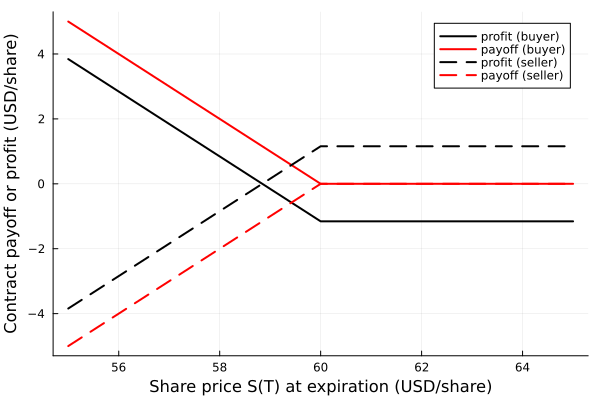

In [31]:
plot(profit_array[:,1],profit_array[:,2], c=:black, label="profit (buyer)", lw=2)
plot!(payoff_array[:,1],payoff_array[:,end], c=:red, label="payoff (buyer)", lw=2)
plot!(profit_array[:,1],-1*profit_array[:,2], c=:black, label="profit (seller)", linestyle=:dash, lw=2)
plot!(payoff_array[:,1],-1*payoff_array[:,end], c=:red, label="payoff (seller)", linestyle=:dash, lw=2)
xlabel!("Share price S(T) at expiration (USD/share)",fontsize=18)
ylabel!("Contract payoff or profit (USD/share)",fontsize=18)

### What is the difference between the payoff/profit for an American versus European `put` contract?
The payoff curves for American and European `put` contracts are the same, but the profit curves differ due to the higher premium of the American contract caused by its increased exercise risk. Let’s examine this from the buyer’s perspective. The profit curve for the American contract will be shifted down relative to a European contract with the same parameters:

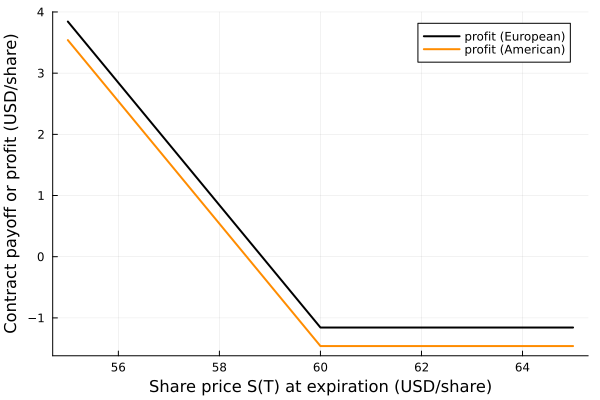

In [30]:
plot(profit_array[:,1],profit_array[:,2], c=:black, label="profit (European)", lw=2)
plot!(american_profit_array[:,1],american_profit_array[:,2], c=:darkorange, label="profit (American)", lw=2)
xlabel!("Share price S(T) at expiration (USD/share)",fontsize=18)
ylabel!("Contract payoff or profit (USD/share)",fontsize=18)

### Breakeven

In [41]:
breakeven_american_put = K - P_american_CRR;
println("The breakeven for the American put contract is: B = $(breakeven_american_put) USD/share")

The Breakeven for the American put contract is: B = 58.54 USD/share
